In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import re as re
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics 

# Data exploration

In [2]:
data = pd.read_csv("project/Data_Entry_2017_v2020.csv")
data.head()

# the labels in our dataset
class_labels = ['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation', 'No Finding']

In [3]:
#unconcatenate the label variable
for x in class_labels:
    search = []    
    for values in data['Finding Labels']:
        #print(x)
        y=int(x in values)
        search.append(y)


    data[x] = search

In [4]:
data['female'] = np.where(data['Patient Gender']=='M',0,1)

In [5]:
#frequency of the different variables of interest
new_data=data[['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation', 'No Finding', 'female']]

#new_data.groupby(['female']).sum()
new_data_fem=new_data.groupby(['female']).sum().transpose()
new_data_fem.to_csv('female_proportion.csv')

In [6]:
new_data.sum()

Cardiomegaly           2776
Emphysema              2516
Effusion              13317
Hernia                  227
Infiltration          19894
Mass                   5782
Nodule                 6331
Atelectasis           11559
Pneumothorax           5302
Pleural_Thickening     3385
Pneumonia              1431
Fibrosis               1686
Edema                  2303
Consolidation          4667
No Finding            60361
female                48780
dtype: int64

In [7]:
new_data=data[['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation', 'No Finding', 'Patient Age']]

df2=pd.melt(new_data, id_vars=['Patient Age'], var_name='labels', value_name='age_var')
df2 = df2.drop(df2[df2.age_var ==0 ].index)
df2=df2.drop(columns='age_var')

df2=df2.groupby(['labels']).mean()
df2.to_csv('age_mean.csv')

In [8]:
new_data=new_data.drop(['Patient Age'], axis=1)
new_data=new_data.drop(['No Finding'], axis=1)

In [9]:
df_asint = new_data.astype(int)
coocc = df_asint.T.dot(df_asint)

<AxesSubplot:>

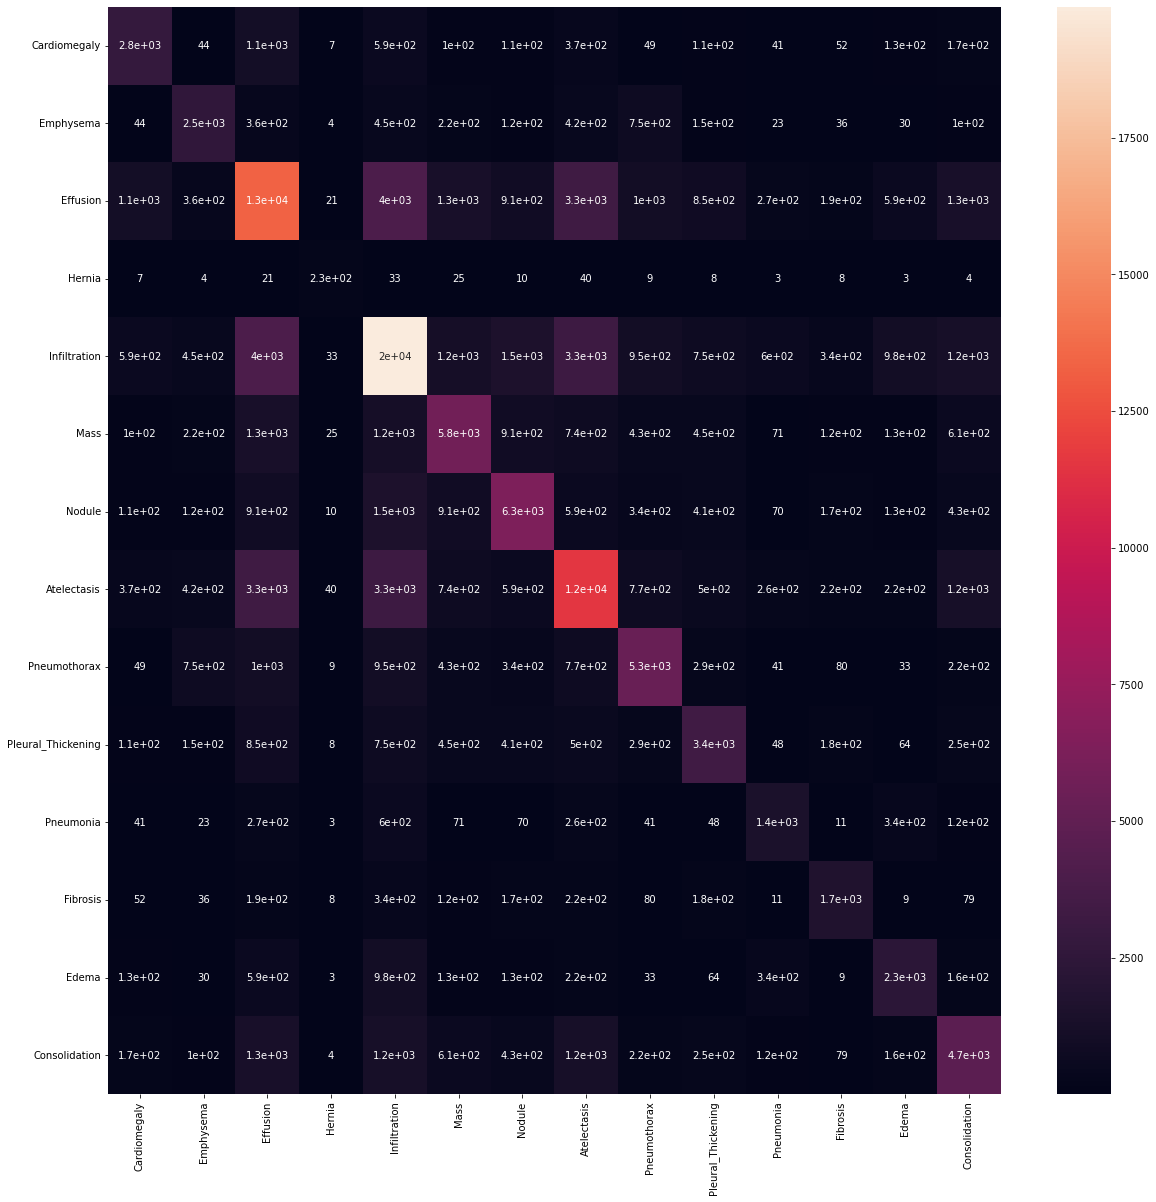

In [10]:
plt.figure(figsize=(20, 20))
sns.heatmap(coocc, annot=True)

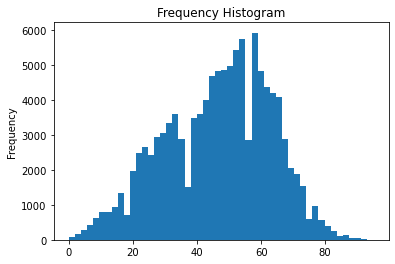

In [11]:
plt.hist(data['Patient Age'], bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [ ]:
# Load top 5 images and display them with Finding labels in 1 x 5 grid
plt.style.use('default')
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # do black and white
    plt.imshow(plt.imread(image_folder +
               data.iloc[i]['Image Index']), cmap="gray")
    plt.title(data.iloc[i]['Finding Labels'])
    plt.axis('off')


<img src="https://github.com/albert-ying/ggRetro/blob/main/README_files/figure-markdown_strict/output.png?raw=true" width="100%" class="center" align=""/>

In [1]:
# add these libraries
#these are specific for gradcam
from keras.models import load_model
from tensorflow import keras

In [ ]:
## Train the CNN for lung x-ray classification
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from tf_keras_vis.gradcam import Gradcam
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config  
import efficientnet.tfkeras as efn
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from joblib import Parallel, delayed
import pickle
np_config.enable_numpy_behavior()

In [3]:
## Load data
dir = 'images/'
files = os.listdir(dir)

## Read the metadata
# out = os.path.isdir("Downloads/Data_Entry_2017_v2020.csv")
# print(out)

df = pd.read_csv('Data_Entry_2017_v2020.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


## The baseline model trained to predict individual conditions (e.g. Cardiomegaly)

In [4]:
## Use first 1000 images to train the model
#note this is only for cardiomegaly
train_img = []

for i in range(1000):
    img = plt.imread(dir + df.iloc[i]['Image Index'])
    img = np.array(img)
    img = img.astype('float32')
    img = img / 255
    train_img.append(img)

In [5]:
# Check the dimensions of the images

## Preprocess the label
train_label = []
## if detected Cardiomegaly in string of Finding Labels, then 1, else 0
for i in range(1000):
    if 'Cardiomegaly' in df.iloc[i]['Finding Labels']:
        train_label.append(1)
    else:
        train_label.append(0)



In [6]:
# get the index where the shape of train img not (1024, 1024), remove them from both img and label
bad_index = []
for i in range(len(train_img)):
    if train_img[i- len(bad_index)].shape != (1024, 1024):
        del train_img[i - len(bad_index)]
        del train_label[i - len(bad_index)]
        bad_index.append(i)



In [7]:
train_img = np.array(train_img)
train_label = np.array(train_label)

In [ ]:
## Build the CNN
input_shape = (1024, 1024, 1)
input_layer = Input(shape=input_shape)
conv_1 = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(pool_2)
pool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
flat = Flatten()(pool_3)
den_2 = Dense(512, activation='relu')(flat)
output_layer = Dense(1, activation='sigmoid')(den_2)

## compile the model
base_model = Model(inputs=input_layer, outputs=output_layer)
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()

## Train the model
history = base_model.fit(train_img, train_label, epochs=4, verbose=1, validation_split=0.2)

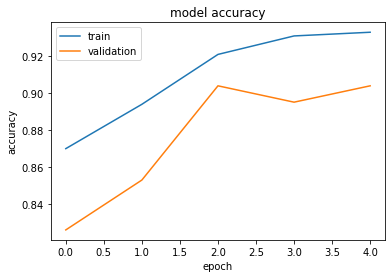

In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [8]:
base_model = load_model('base_model.h5')

2022-05-07 15:45:45.851845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 15:45:45.938902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 15:45:45.939554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 15:45:45.940378: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [47]:
# this is how you load in imagenet
# model_builder = keras.applications.xception.Xception
# base_model = model_builder(weights="imagenet")


91897856/91884032 [==============================] - 4s 0us/step


In [9]:
base_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1024, 1024, 1)]   0         
                                                                 
 conv2d_19 (Conv2D)          (None, 1024, 1024, 8)     656       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 341, 341, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 341, 341, 16)      10384     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 113, 113, 16)     0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 204304)            0   

## GRAD-CAM implementation on the baseline model

In [10]:
# Let the last layer be the last layer of the CNN

#if sing image net this should be 'block14_sepconv2_act' I'm pretty sure
last_layer= 'conv2d_20'

In [11]:
# # in case we need this
#fig, ax = plt.subplots(1, 1, figsize=(12,12))
# # ax.imshow(raw)

# grad_model = tf.keras.models.Model(
#         [base_model.inputs], [base_model.get_layer(last_layer).output, base_model.output]
#     )
# pred_index= None
# with tf.GradientTape() as tape:
#     last_conv_layer_output, preds = grad_model(input_image)
#     if pred_index is None:
#         pred_index = tf.argmax(preds[0])
#     class_channel = preds[:, pred_index]

In [12]:
# function that turns an image into an array
def image_to_array(input_index):
    raw = train_img[input_index]
    input_image = np.expand_dims(raw,axis=0)
    return input_image

In [13]:
#you can use any image
# preferably we would find one that predicts a certain disease and use that as an example
correct_index= 96
img_array = image_to_array(correct_index)

In [23]:
# adapted from https://keras.io/examples/vision/grad_cam/
def gradcam_heatmap(image, model, last_layer, pred_index=None):
    # create a model that maps the input image to last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_layer).output, model.output]
    )
    # then compute gradient of top predicted classs\
    with tf.GradientTape() as tape:
        last_layer, preds = grad_model(image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
# gradient of output neuron
    grads = tape.gradient(class_channel, last_layer)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # sum all the channels to obtain the heatmap class activation
    last_layer_output = last_layer[0]
    heatmap = last_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

prediction is 0
classification is


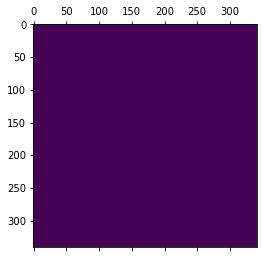

In [24]:
model = base_model

# Remove last layer's softmax
model.layers[-1].acxtivation = None

# Print what the top predicted class is
preds = np.argmax(model.predict(img_array))
# why does it predict the same number all the time. that cannot be correct.
print('prediction is', preds)
print('classification is')

# Generate class activation heatmap
heatmap = gradcam_heatmap(img_array, model, last_layer)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [26]:
#you can use any image
# preferably we would find one that predicts a certain disease and use that as an example
incorrect_index = 30
inc_img_array = image_to_array(incorrect_index)

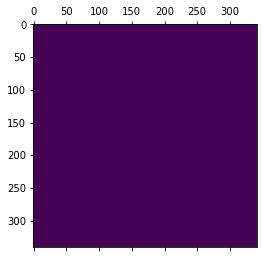

In [28]:
heatmap = gradcam_heatmap(inc_img_array, model, last_layer)
plt.matshow(heatmap)
plt.show()

## Apply the custom loss function

In [ ]:
# Create 'get_custom_multitask_weighted_loss' with pos_w (positive weights for each class)
# and neg_w (negative weights for each class) as inputs, returns 'custom_multitask_weighted_loss' function
## Inspired from course lecture for Module A (Apr 25, 2022 by Kathy Feiyang)

eps=1e-7
def get_custom_multitask_weighted_loss(pos_w, neg_w):
    def custom_multitask_weighted_loss(y_true, y_pred):
        # For each class, sum the average weighted loss
        weighted_loss = 0.0 # set the initial loss to 0
        for myclass in range(len(pos_w)):
            neg_w_loss = -1 * K.mean(neg_w[myclass] * (1-y_true[:,myclass]) * K.log(1-y_pred[:,myclass]+eps)) # negative weights
            pos_w_loss = -1 * K.mean(pos_w[myclass] * y_true[:,myclass] * K.log(y_pred[:,myclass]+eps)) # positive weights
            weighted_loss += neg_w_loss + pos_w_loss # sum pos and neg loss to get total loss 
        return weighted_loss
    return custom_multitask_weighted_loss

## Train the model with custom loss function and transfer learning

In [ ]:
#unconcatenate the label variable
new_df = df[['Image Index']]
for x in class_labels:
    search = []    
    for values in df['Finding Labels']:
        #print(x)
        y=int(x in values)
        search.append(y)
    new_df[x] = search
new_df = new_df.drop(['No Finding'], axis=1)

In [ ]:

dir = 'images/images/'
imgs = []
for i in range(2000):
    img = plt.imread(dir + df.iloc[i]['Image Index'])
    img = np.array(img)
    img = img.astype('float32')
    img = img / 255
    print(i)
    print(img.shape)
    imgs.append(img)
# print 12 rows of the dataframe

ids = new_df['Image Index'].values[:2000].tolist()

labels = new_df.drop(['Image Index'], axis=1).values[:2000].tolist()

def filter_image_label(img, label, id):
    bad_index = []
    for i in range(len(img)):
        if img[i- len(bad_index)].shape != (1024, 1024):
            del img[i - len(bad_index)]
            del label[i - len(bad_index)]
            del id[i - len(bad_index)]
            bad_index.append(i)
    img = np.array(img)
    label = np.array(label)
    # convert the labels to integers
    label = label.astype(np.int64)
    id = np.array(id)
    return img, label, id

imgs_f, labels_f, ids_f = filter_image_label(imgs, labels, ids)

## Split the data into training and testing
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    imgs_f, labels_f, ids_f, test_size=0.3, random_state=42
)

In [ ]:
## Compute the weight
N = y_train.shape[0]
N_out = y_train.shape[1]
positive_frequencies = (y_train.sum(axis = 0))/N
negative_frequencies = 1.0 - positive_frequencies
pos_weights = np.array(negative_frequencies)
neg_weights = np.array(positive_frequencies)

In [ ]:
def create_model_efnB0(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = efn.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor
        )
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x) 
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

IMAGE_SIZE = [1024,1024]
model = create_model_efnB0((*IMAGE_SIZE, 3), n_out=14)
model.summary()

<img src="https://github.com/albert-ying/ggRetro/blob/main/README_files/figure-markdown_strict/model2_summary.png?raw=true" width="40%" class="center" align=""/>

In [ ]:
custom_loss = get_custom_multitask_weighted_loss(pos_weights, neg_weights)
with open('custom_loss.pkl', 'wb') as f:
    pickle.dump(custom_loss, f)

model.compile(
    loss=get_custom_multitask_weighted_loss(pos_weights, neg_weights),
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

## Train the model
X_train_3 = np.zeros(
    (np.array(X_train).shape[0], np.array(X_train).shape[1],  np.array(X_train).shape[2], 3)
)
X_train_3[:,:,:,0] = X_train # same value in each channel
X_train_3[:,:,:,1] = X_train
X_train_3[:,:,:,2] = X_train
X_test_3 = np.zeros(
    (np.array(X_test).shape[0], np.array(X_test).shape[1],  np.array(X_test).shape[2], 3)
)
X_test_3[:,:,:,0] = X_test # same value in each channel
X_test_3[:,:,:,1] = X_test
X_test_3[:,:,:,2] = X_test
history = model.fit(X_train_3, y_train, epochs=10, verbose=1, validation_split=0.2)

## Save the history of the model
with open('history_model_1.pkl', 'wb') as f:
    pickle.dump(history.history, f)
## plot the accuracy across epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<img src="https://github.com/albert-ying/ggRetro/blob/main/README_files/figure-markdown_strict/base_line_accuracy.png?raw=true" width="50%" class="center" align=""/>

In [ ]:
# save the plot
plt.savefig('line_accuracy.png')

### Save the full model
model.save('model.h5')

# Results


In [12]:
#Read in predictions for the training set
train_results = pd.read_csv("train_pred_new.csv")
train_results.head()

,Unnamed: 0,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000344_000.png,0.043726,0.051846,0.037107,0.010630,0.039865,0.011301,0.009506,0.092708,0.000160,0.168378,0.337250,0.061666,0.404454,0.272468
1,00000193_005.png,0.121301,0.128584,0.045677,0.053116,0.740591,0.002146,0.000958,0.046893,0.000606,0.133584,0.036636,0.350354,0.421865,0.193881
2,00000484_000.png,0.128970,0.054866,0.124624,0.031580,0.810682,0.002649,0.004153,0.146214,0.001253,0.059315,0.131239,0.413718,0.770256,0.574065
3,00000156_001.png,0.051884,0.053984,0.069933,0.030373,0.173674,0.004492,0.002877,0.086472,0.000131,0.210045,0.141229,0.173270,0.428351,0.197097
4,00000416_008.png,0.092125,0.064106,0.054881,0.042089,0.480548,0.002229,0.001443,0.061059,0.000263,0.099129,0.085246,0.274249,0.498059,0.250178


In [13]:
#add a suffix to the train results to differentiate from actual labels
train_results=train_results.add_suffix('_col')
train_results=train_results.rename(columns={"Unnamed: 0_col": "Image Index"})

In [14]:
train_results.head()

,Image Index,Cardiomegaly_col,Emphysema_col,Effusion_col,Hernia_col,Infiltration_col,Mass_col,Nodule_col,Atelectasis_col,Pneumothorax_col,Pleural_Thickening_col,Pneumonia_col,Fibrosis_col,Edema_col,Consolidation_col
0,00000344_000.png,0.043726,0.051846,0.037107,0.010630,0.039865,0.011301,0.009506,0.092708,0.000160,0.168378,0.337250,0.061666,0.404454,0.272468
1,00000193_005.png,0.121301,0.128584,0.045677,0.053116,0.740591,0.002146,0.000958,0.046893,0.000606,0.133584,0.036636,0.350354,0.421865,0.193881
2,00000484_000.png,0.128970,0.054866,0.124624,0.031580,0.810682,0.002649,0.004153,0.146214,0.001253,0.059315,0.131239,0.413718,0.770256,0.574065
3,00000156_001.png,0.051884,0.053984,0.069933,0.030373,0.173674,0.004492,0.002877,0.086472,0.000131,0.210045,0.141229,0.173270,0.428351,0.197097
4,00000416_008.png,0.092125,0.064106,0.054881,0.042089,0.480548,0.002229,0.001443,0.061059,0.000263,0.099129,0.085246,0.274249,0.498059,0.250178


In [15]:
#merge in true labels
merged_train = pd.merge(train_results, data)

#remove observations that do not match
merged_train = merged_train.dropna()

In [16]:
merged_train.shape

(1377, 41)

In [17]:
merged_train.head()

,Image Index,Cardiomegaly_col,Emphysema_col,Effusion_col,Hernia_col,Infiltration_col,Mass_col,Nodule_col,Atelectasis_col,Pneumothorax_col,...,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,No Finding,female
0,00000344_000.png,0.043726,0.051846,0.037107,0.010630,0.039865,0.011301,0.009506,0.092708,0.000160,...,0,0,0,1,0,0,0,1,0,0
1,00000193_005.png,0.121301,0.128584,0.045677,0.053116,0.740591,0.002146,0.000958,0.046893,0.000606,...,0,0,0,0,0,0,0,0,1,0
2,00000484_000.png,0.128970,0.054866,0.124624,0.031580,0.810682,0.002649,0.004153,0.146214,0.001253,...,0,0,0,0,0,0,0,0,1,0
3,00000156_001.png,0.051884,0.053984,0.069933,0.030373,0.173674,0.004492,0.002877,0.086472,0.000131,...,0,0,0,0,0,0,0,0,0,0
4,00000416_008.png,0.092125,0.064106,0.054881,0.042089,0.480548,0.002229,0.001443,0.061059,0.000263,...,0,0,0,0,0,0,0,0,0,1


Best Threshold for cardiomegaly=0.126047, G-Mean=0.523
Best Threshold for emphysema=0.110157, G-Mean=0.529
Best Threshold for effusion=0.050646, G-Mean=0.569
Best Threshold for hernia=0.048910, G-Mean=0.685
Best Threshold for infiltration=0.691400, G-Mean=0.489
Best Threshold for mass=0.002377, G-Mean=0.550
Best Threshold for nodule=0.001229, G-Mean=0.551
Best Threshold for Atelectasis=0.056811, G-Mean=0.591
Best Threshold for pneumothorax=0.000620, G-Mean=0.649
Best Threshold for Pleural Thickening=0.121775, G-Mean=0.517
Best Threshold for pneumonia=0.252682, G-Mean=0.666
Best Threshold for fibrosis=0.300847, G-Mean=0.582
Best Threshold for Edema=0.479523, G-Mean=0.507
Best Threshold for Consolidation=0.258809, G-Mean=0.521


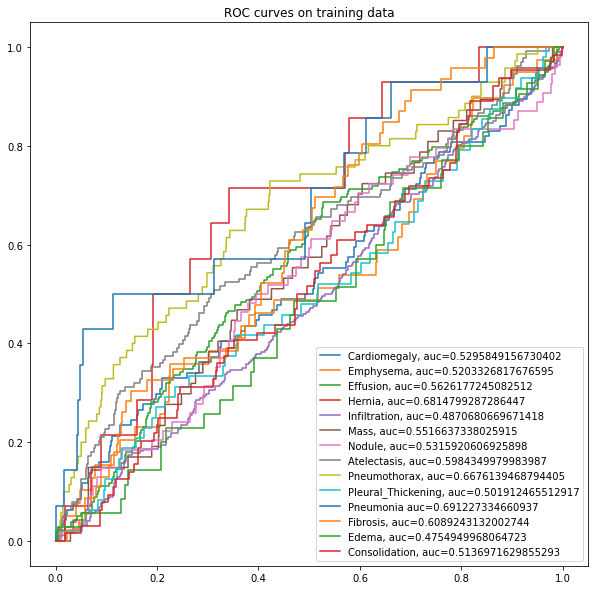

In [18]:
#Defining thresholds based on the ROC curves
plt.rcParams["figure.figsize"] = (10,10)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Cardiomegaly'],  merged_train['Cardiomegaly_col'])
auc = metrics.roc_auc_score(merged_train['Cardiomegaly'],  merged_train['Cardiomegaly_col'])
plt.plot(fpr,tpr,label="Cardiomegaly, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for cardiomegaly=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
cardiomegaly_threshold=thresh[ix]
#df3['Cardiomegaly_col']=(df3['Cardiomegaly_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Emphysema'],  merged_train['Emphysema_col'])
auc = metrics.roc_auc_score(merged_train['Emphysema'],  merged_train['Emphysema_col'])
plt.plot(fpr,tpr,label="Emphysema, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for emphysema=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
emphysema_threshold=thresh[ix]
#df3['Emphysema_col']=(df3['Emphysema_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Effusion'],  merged_train['Effusion_col'])
auc = metrics.roc_auc_score(merged_train['Effusion'], merged_train['Effusion_col'])
plt.plot(fpr,tpr,label="Effusion, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for effusion=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
effusion_threshold=thresh[ix]
#df3['Effusion_col']=(df3['Effusion_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Hernia'],  merged_train['Hernia_col'])
auc = metrics.roc_auc_score(merged_train['Hernia'],  merged_train['Hernia_col'])
plt.plot(fpr,tpr,label="Hernia, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for hernia=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
hernia_threshold=thresh[ix]
#df3['Hernia_col']=(df3['Hernia_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Infiltration'],  merged_train['Infiltration_col'])
auc = metrics.roc_auc_score(merged_train['Infiltration'],  merged_train['Infiltration_col'])
plt.plot(fpr,tpr,label="Infiltration, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for infiltration=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
infiltration_threshold=thresh[ix]
#df3['Infiltration_col']=(df3['Infiltration_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Mass'],  merged_train['Mass_col'])
auc = metrics.roc_auc_score(merged_train['Mass'],  merged_train['Mass_col'])
plt.plot(fpr,tpr,label="Mass, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for mass=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
mass_threshold=thresh[ix]
#df3['Mass_col']=(df3['Mass_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Nodule'],  merged_train['Nodule_col'])
auc = metrics.roc_auc_score(merged_train['Nodule'],  merged_train['Nodule_col'])
plt.plot(fpr,tpr,label="Nodule, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for nodule=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
nodule_threshold=thresh[ix]
#df3['Nodule_col']=(df3['Nodule_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Atelectasis'],  merged_train['Atelectasis_col'])
auc = metrics.roc_auc_score(merged_train['Atelectasis'],  merged_train['Atelectasis_col'])
plt.plot(fpr,tpr,label="Atelectasis, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Atelectasis=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
atelectasis_threshold=thresh[ix]
#df3['Atelectasis_col']=(df3['Atelectasis_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Pneumothorax'],  merged_train['Pneumothorax_col'])
auc = metrics.roc_auc_score(merged_train['Pneumothorax'],  merged_train['Pneumothorax_col'])
plt.plot(fpr,tpr,label="Pneumothorax, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for pneumothorax=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
pneumothorax_threshold=thresh[ix]
#df3['Pneumothorax_col']=(df3['Pneumothorax_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Pleural_Thickening'],  merged_train['Pleural_Thickening_col'])
auc = metrics.roc_auc_score(merged_train['Pleural_Thickening'],  merged_train['Pleural_Thickening_col'])
plt.plot(fpr,tpr,label="Pleural_Thickening, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Pleural Thickening=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
pleural_thickening_threshold=thresh[ix]
#df3['Pleural_Thickening_col']=(df3['Pleural_Thickening_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Pneumonia'],  merged_train['Pneumonia_col'])
auc = metrics.roc_auc_score(merged_train['Pneumonia'],  merged_train['Pneumonia_col'])
plt.plot(fpr,tpr,label="Pneumonia auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for pneumonia=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
pneumonia_threshold=thresh[ix]
#df3['Pneumonia_col']=(df3['Pneumonia_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Fibrosis'],  merged_train['Fibrosis_col'])
auc = metrics.roc_auc_score(merged_train['Fibrosis'],  merged_train['Fibrosis_col'])
plt.plot(fpr,tpr,label="Fibrosis, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for fibrosis=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
fibrosis_threshold=thresh[ix]
#df3['Fibrosis_col']=(df3['Fibrosis_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Edema'],  merged_train['Edema_col'])
auc = metrics.roc_auc_score(merged_train['Edema'],  merged_train['Edema_col'])
plt.plot(fpr,tpr,label="Edema, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Edema=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
edema_threshold=thresh[ix]
#df3['Edema_col']=(df3['Edema_col'] > thresh[ix]).astype(int)

fpr, tpr, thresh = metrics.roc_curve(merged_train['Consolidation'],  merged_train['Consolidation_col'])
auc = metrics.roc_auc_score(merged_train['Consolidation'],  merged_train['Consolidation_col'])
plt.plot(fpr,tpr,label="Consolidation, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Consolidation=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
consolidation_threshold=thresh[ix]
#df3['Consolidation_col']=(df3['Consolidation_col'] > thresh[ix]).astype(int)

plt.title("ROC curves on training data")
plt.legend(loc=0)

In [19]:
#check for accuracy on test set
test_results = pd.read_csv("test_pred.csv")
test_results.head()


,Unnamed: 0,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000211_030.png,0.146651,0.085209,0.062725,0.038281,0.569806,0.001435,0.001036,0.053200,0.000566,0.076344,0.064749,0.333493,0.570206,0.340561
1,00000398_001.png,0.057678,0.028697,0.320640,0.014533,0.254402,0.003177,0.012473,0.161548,0.000163,0.041371,0.448870,0.077758,0.787432,0.434291
2,00000013_042.png,0.286526,0.113630,0.076820,0.145815,0.689243,0.004276,0.003152,0.057424,0.002015,0.129573,0.048600,0.650820,0.385649,0.237233
3,00000275_004.png,0.132342,0.100639,0.053334,0.051844,0.664990,0.001795,0.000836,0.035985,0.000503,0.113609,0.040690,0.329867,0.458669,0.242813
4,00000211_032.png,0.158025,0.043562,0.192404,0.009995,0.871864,0.001811,0.007537,0.162348,0.000926,0.016457,0.301202,0.231292,0.895149,0.820748


In [20]:
test_results=test_results.add_suffix('_col')
test_results=test_results.rename(columns={"Unnamed: 0_col": "Image Index"})

In [21]:
#merge in true labels
merged_test = pd.merge(test_results, data)

#remove observations that do not match
merged_test = merged_test.dropna()

In [22]:
#change predictions to match the threshold
merged_test['Cardiomegaly_col']=(merged_test['Cardiomegaly_col'] > cardiomegaly_threshold).astype(int)
merged_test['Emphysema_col']=(merged_test['Emphysema_col'] > emphysema_threshold).astype(int)
merged_test['Effusion_col']=(merged_test['Effusion_col'] > effusion_threshold).astype(int)
merged_test['Hernia_col']=(merged_test['Hernia_col'] > hernia_threshold).astype(int)
merged_test['Infiltration_col']=(merged_test['Infiltration_col'] > infiltration_threshold).astype(int)
merged_test['Mass_col']=(merged_test['Mass_col'] > mass_threshold).astype(int)
merged_test['Nodule_col']=(merged_test['Nodule_col'] > nodule_threshold).astype(int)
merged_test['Pneumothorax_col']=(merged_test['Pneumothorax_col'] > pneumothorax_threshold).astype(int)
merged_test['Atelectasis_col']=(merged_test['Atelectasis_col'] > atelectasis_threshold).astype(int)
merged_test['Pneumonia_col']=(merged_test['Pneumonia_col'] > pneumonia_threshold).astype(int)
merged_test['Fibrosis_col']=(merged_test['Fibrosis_col'] > fibrosis_threshold).astype(int)
merged_test['Edema_col']=(merged_test['Edema_col'] > edema_threshold).astype(int)
merged_test['Consolidation_col']=(merged_test['Consolidation_col'] > consolidation_threshold).astype(int)
merged_test['Pleural_Thickening_col']=(merged_test['Pleural_Thickening_col'] > pleural_thickening_threshold).astype(int)

In [23]:
merged_test_orig=merged_test[['Cardiomegaly','Emphysema', 'Effusion','Hernia',
 'Infiltration','Mass','Nodule','Atelectasis','Pneumothorax','Pleural_Thickening','Pneumonia','Fibrosis',
 'Edema','Consolidation']]
merged_test_pred=merged_test[['Cardiomegaly_col','Emphysema_col','Effusion_col', 'Hernia_col',
 'Infiltration_col','Mass_col','Nodule_col','Atelectasis_col','Pneumothorax_col','Pleural_Thickening_col',
 'Pneumonia_col','Fibrosis_col','Edema_col','Consolidation_col']]

In [24]:
merged_test_pred.head()

,Cardiomegaly_col,Emphysema_col,Effusion_col,Hernia_col,Infiltration_col,Mass_col,Nodule_col,Atelectasis_col,Pneumothorax_col,Pleural_Thickening_col,Pneumonia_col,Fibrosis_col,Edema_col,Consolidation_col
0,1,0,1,0,0,0,0,0,0,0,0,1,1,1
1,0,0,1,0,0,1,1,1,0,0,1,0,1,1
2,1,1,1,1,0,1,1,1,1,1,0,1,0,0
3,1,0,1,1,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0,1,0,1,1,1,0,1,0,1,1


In [25]:
cm=metrics.multilabel_confusion_matrix(merged_test_orig, merged_test_pred)

results=[]
for i in range(14):
    TN=cm[i][0][0]
    FN=cm[i][1][0]
    TP=cm[i][1][1]
    FP=cm[i][0][1]
    
    # Sensitivity
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # False positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
   
    line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
    results.append(line)
    
test_results_rate = pd.DataFrame(results)


In [26]:
test_results_rate.columns =['TPR', 'TNR', 'FPR', 'FNR']

In [27]:
test_results_rate

,TPR,TNR,FPR,FNR
0,0.34,0.57,0.43,0.66
1,0.30,0.65,0.35,0.70
2,0.63,0.42,0.58,0.37
3,0.67,0.66,0.34,0.33
4,0.35,0.64,0.36,0.65
5,0.39,0.61,0.39,0.61
6,0.66,0.48,0.52,0.34
7,0.42,0.63,0.37,0.58
8,0.61,0.57,0.43,0.39
9,0.44,0.65,0.35,0.56


# Testing for equity across age groups

In [28]:
#Divide the dataframe into 3 bins
bins= [0,35,50,110]
labels = ['Under 35', '35-50', 'over 50']
merged_test['AgeGroup'] = pd.cut(merged_test['Patient Age'], bins=bins, labels=labels, right=False)
UniqueNames = merged_test['AgeGroup'].unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = merged_test[:][merged_test['AgeGroup'] == key]
    
Under35=DataFrameDict['Under 35']
Bw35_50=DataFrameDict['35-50']
Over50=DataFrameDict['over 50']

In [29]:
Bw35_50[['Cardiomegaly_col', 'Cardiomegaly']]

,Cardiomegaly_col,Cardiomegaly
11,1,0
18,0,0
21,1,0
25,1,0
29,1,0
...,...,...
563,0,0
573,1,0
576,0,0
586,0,0


In [30]:
#subset these into test and predictions
Under35_orig=Under35[['Cardiomegaly','Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass',
 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']]
Under35_pred=Under35[['Cardiomegaly_col', 'Emphysema_col','Effusion_col','Hernia_col', 'Infiltration_col',
 'Mass_col', 'Nodule_col', 'Atelectasis_col', 'Pneumothorax_col', 'Pleural_Thickening_col', 'Pneumonia_col',
 'Fibrosis_col', 'Edema_col', 'Consolidation_col']]
Over50_orig=Over50[['Cardiomegaly','Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass',
 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']]
Over50_pred=Over50[['Cardiomegaly_col', 'Emphysema_col','Effusion_col','Hernia_col', 'Infiltration_col',
 'Mass_col', 'Nodule_col', 'Atelectasis_col', 'Pneumothorax_col', 'Pleural_Thickening_col', 'Pneumonia_col',
 'Fibrosis_col', 'Edema_col', 'Consolidation_col']]
Bw35_50_orig=Bw35_50[['Cardiomegaly','Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass',
 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']]
Bw35_50_pred=Bw35_50[['Cardiomegaly_col', 'Emphysema_col','Effusion_col','Hernia_col', 'Infiltration_col',
 'Mass_col', 'Nodule_col', 'Atelectasis_col', 'Pneumothorax_col', 'Pleural_Thickening_col', 'Pneumonia_col',
 'Fibrosis_col', 'Edema_col', 'Consolidation_col']]

In [31]:
#how accurate is our model for different age groups and different conditions
cm=metrics.multilabel_confusion_matrix(Under35_orig, Under35_pred)
results=[]
for i in range(14):
    TN=cm[i][0][0]
    FN=cm[i][1][0]
    TP=cm[i][1][1]
    FP=cm[i][0][1]
    
     # Sensitivity
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # False positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
    results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df.to_csv('under35_results.csv')

/tmp/ipykernel_218/1657234598.py:11: RuntimeWarning: invalid value encountered in long_scalars
  TPR = TP/(TP+FN)
/tmp/ipykernel_218/1657234598.py:21: RuntimeWarning: invalid value encountered in long_scalars
  FNR = FN/(TP+FN)


In [32]:
df

,TPR,TNR,FPR,FNR
0,NaN,0.62,0.38,NaN
1,0.00,0.60,0.40,1.00
2,0.40,0.37,0.63,0.60
3,NaN,0.67,0.33,NaN
4,0.29,0.66,0.34,0.71
5,0.00,0.46,0.54,1.00
6,0.71,0.40,0.60,0.29
7,0.80,0.58,0.42,0.20
8,0.00,0.59,0.41,1.00
9,1.00,0.62,0.38,0.00


In [33]:
cm=metrics.multilabel_confusion_matrix(Bw35_50_orig, Bw35_50_pred)
results=[]
for i in range(14):
    TN=cm[i][0][0]
    FN=cm[i][1][0]
    TP=cm[i][1][1]
    FP=cm[i][0][1]
    
     # Sensitivity
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # False positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)

    line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
    results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df.to_csv('Bw35_50_results.csv')

/tmp/ipykernel_218/3336389950.py:10: RuntimeWarning: invalid value encountered in long_scalars
  TPR = TP/(TP+FN)
/tmp/ipykernel_218/3336389950.py:17: RuntimeWarning: invalid value encountered in long_scalars
  FNR = FN/(TP+FN)


In [34]:
df

,TPR,TNR,FPR,FNR
0,0.33,0.63,0.37,0.67
1,NaN,0.64,0.36,NaN
2,0.67,0.44,0.56,0.33
3,NaN,0.73,0.27,NaN
4,0.25,0.62,0.38,0.75
5,0.50,0.60,0.40,0.50
6,1.00,0.46,0.54,0.00
7,0.55,0.60,0.40,0.45
8,1.00,0.60,0.40,0.00
9,0.67,0.61,0.39,0.33


In [35]:
cm=metrics.multilabel_confusion_matrix(Over50_orig, Over50_pred)

results=[]
for i in range(14):
    TN=cm[i][0][0]
    FN=cm[i][1][0]
    TP=cm[i][1][1]
    FP=cm[i][0][1]
    
     # Sensitivity
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # False positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
    results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df.to_csv('over50_results.csv')

In [36]:
df

,TPR,TNR,FPR,FNR
0,0.34,0.55,0.45,0.66
1,0.31,0.66,0.34,0.69
2,0.65,0.42,0.58,0.35
3,0.67,0.65,0.35,0.33
4,0.38,0.64,0.36,0.62
5,0.40,0.63,0.37,0.60
6,0.60,0.49,0.51,0.40
7,0.33,0.64,0.36,0.67
8,0.72,0.57,0.43,0.28
9,0.36,0.67,0.33,0.64


# Improving predictions for sub-groups

In [37]:
#Divide the dataframe into 3 bins
bins= [0,35,50,110]
labels = ['Under 35', '35-50', 'over 50']
merged_train['AgeGroup'] = pd.cut(merged_train['Patient Age'], bins=bins, labels=labels, right=False)
UniqueNames = merged_train['AgeGroup'].unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = merged_train[:][merged_train['AgeGroup'] == key]
    
Under35_train=DataFrameDict['Under 35']
Bw35_50_train=DataFrameDict['35-50']
Over50_train=DataFrameDict['over 50']

Best Threshold for Cardiomegaly under 35=0.156936, G-Mean=0.659
Best Threshold for Cardiomegaly under 35=0.117378, G-Mean=0.580
Best Threshold for Cardiomegaly for over 50=0.126047, G-Mean=0.516


Text(0.5, 1.0, 'Cardiomegaly for different age groups')

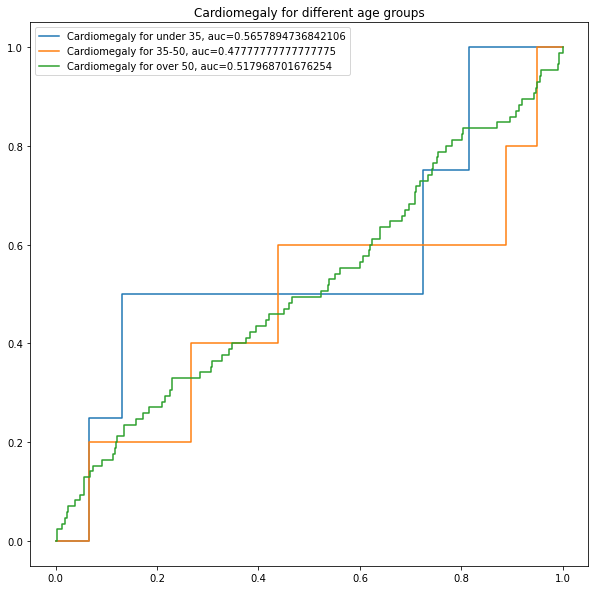

In [38]:
plt.rcParams["figure.figsize"] = (10,10)

fpr, tpr, thresh = metrics.roc_curve(Under35_train['Cardiomegaly'],  Under35_train['Cardiomegaly_col'])
auc = metrics.roc_auc_score(Under35_train['Cardiomegaly'],  Under35_train['Cardiomegaly_col'])
plt.plot(fpr,tpr,label="Cardiomegaly for under 35, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Cardiomegaly under 35=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
under_35_threshold=thresh[ix]

fpr, tpr, thresh = metrics.roc_curve(Bw35_50_train['Cardiomegaly'],  Bw35_50_train['Cardiomegaly_col'])
auc = metrics.roc_auc_score(Bw35_50_train['Cardiomegaly'],  Bw35_50_train['Cardiomegaly_col'])
plt.plot(fpr,tpr,label="Cardiomegaly for 35-50, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Cardiomegaly under 35=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
bw35_50_threshold=thresh[ix]

fpr, tpr, thresh = metrics.roc_curve(Over50_train['Cardiomegaly'],  Over50_train['Cardiomegaly_col'])
auc = metrics.roc_auc_score(Over50_train['Cardiomegaly'],  Over50_train['Cardiomegaly_col'])
plt.plot(fpr,tpr,label="Cardiomegaly for over 50, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Cardiomegaly for over 50=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
over_50_threshold=thresh[ix]

plt.legend(loc=0)
plt.title("Cardiomegaly for different age groups")

In [39]:
bins= [0,35,50,110]
labels = ['Under 35', '35-50', 'over 50']
merged_test['AgeGroup'] = pd.cut(merged_test['Patient Age'], bins=bins, labels=labels, right=False)
UniqueNames = merged_test['AgeGroup'].unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = merged_test[:][merged_test['AgeGroup'] == key]
    
Under35=DataFrameDict['Under 35']
Bw35_50=DataFrameDict['35-50']
Over50=DataFrameDict['over 50']

In [40]:
Under35['Cardiomegaly_col']= (Under35['Cardiomegaly_col'] > under_35_threshold).astype(int)
Bw35_50['Cardiomegaly_col']= (Bw35_50['Cardiomegaly_col'] > bw35_50_threshold).astype(int)
Over50['Cardiomegaly_col']= (Over50['Cardiomegaly_col'] > over_50_threshold).astype(int)

In [41]:
cm=metrics.confusion_matrix(Under35['Cardiomegaly'], Under35['Cardiomegaly_col'])
results=[]

TN=cm[0][0]
FN=cm[1][0]
TP=cm[1][1]
FP=cm[0][1]
    
# Sensitivity
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# False positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df

/tmp/ipykernel_218/1552524302.py:10: RuntimeWarning: invalid value encountered in long_scalars
  TPR = TP/(TP+FN)
/tmp/ipykernel_218/1552524302.py:16: RuntimeWarning: invalid value encountered in long_scalars
  FNR = FN/(TP+FN)


,TPR,TNR,FPR,FNR
0,NaN,0.62,0.38,NaN


In [42]:
df

,TPR,TNR,FPR,FNR
0,NaN,0.62,0.38,NaN


In [43]:
cm=metrics.confusion_matrix(Bw35_50['Cardiomegaly'], Bw35_50['Cardiomegaly_col'])
results=[]

TN=cm[0][0]
FN=cm[1][0]
TP=cm[1][1]
FP=cm[0][1]
    
# Sensitivity
TPR = TP/(TP+FN)
# Specificity
TNR = TN/(TN+FP) 
# False positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df

,TPR,TNR,FPR,FNR
0,0.33,0.63,0.37,0.67


In [44]:
cm=metrics.confusion_matrix(Over50['Cardiomegaly'], Over50['Cardiomegaly_col'])
results=[]

TN=cm[0][0]
FN=cm[1][0]
TP=cm[1][1]
FP=cm[0][1]
    
# Sensitivity
TPR = TP/(TP+FN)
# Specificity
TNR = TN/(TN+FP) 
# False positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df

,TPR,TNR,FPR,FNR
0,0.34,0.55,0.45,0.66


Best Threshold for Pneumonia under 35=0.380864, G-Mean=0.730
Best Threshold for Pneumonia under 35=0.366011, G-Mean=0.964
Best Threshold for Pneumonia for over 50=0.060027, G-Mean=0.621


Text(0.5, 1.0, 'Pneumonia for different age groups')

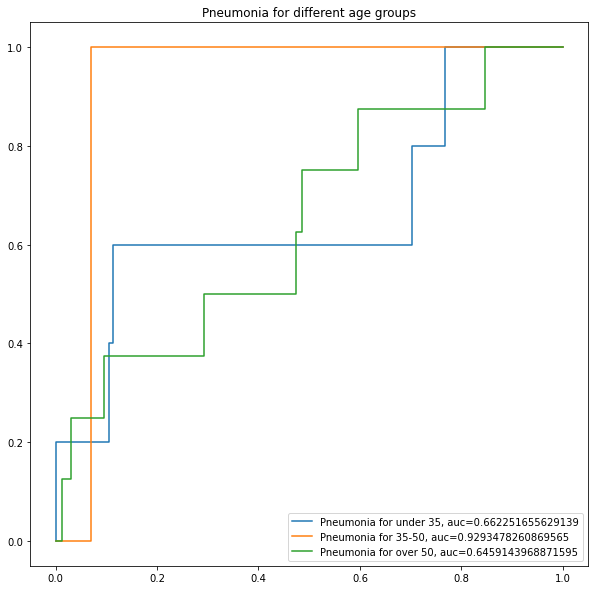

In [45]:
#checking this for pneumonia
plt.rcParams["figure.figsize"] = (10,10)

fpr, tpr, thresh = metrics.roc_curve(Under35_train['Pneumonia'],  Under35_train['Pneumonia_col'])
auc = metrics.roc_auc_score(Under35_train['Pneumonia'],  Under35_train['Pneumonia_col'])
plt.plot(fpr,tpr,label="Pneumonia for under 35, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Pneumonia under 35=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
under_35_threshold=thresh[ix]

fpr, tpr, thresh = metrics.roc_curve(Bw35_50_train['Pneumonia'],  Bw35_50_train['Pneumonia_col'])
auc = metrics.roc_auc_score(Bw35_50_train['Pneumonia'],  Bw35_50_train['Pneumonia_col'])
plt.plot(fpr,tpr,label="Pneumonia for 35-50, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Pneumonia under 35=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
bw35_50_threshold=thresh[ix]

fpr, tpr, thresh = metrics.roc_curve(Over50_train['Pneumonia'],  Over50_train['Pneumonia_col'])
auc = metrics.roc_auc_score(Over50_train['Pneumonia'],  Over50_train['Pneumonia_col'])
plt.plot(fpr,tpr,label="Pneumonia for over 50, auc="+str(auc))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold for Pneumonia for over 50=%f, G-Mean=%.3f' % (thresh[ix], gmeans[ix]))
over_50_threshold=thresh[ix]

plt.legend(loc=0)
plt.title("Pneumonia for different age groups")

In [46]:
Under35['Pneumonia_col']= (Under35['Pneumonia_col'] > under_35_threshold).astype(int)
Bw35_50['Pneumonia_col']= (Bw35_50['Pneumonia_col'] > bw35_50_threshold).astype(int)
Over50['Pneumonia_col']= (Over50['Pneumonia_col'] > over_50_threshold).astype(int)

In [47]:
#Checking for another disease to see improvement
cm=metrics.confusion_matrix(Under35['Pneumonia'], Under35['Pneumonia_col'])
results=[]

TN=cm[0][0]
FN=cm[1][0]
TP=cm[1][1]
FP=cm[0][1]
    
# Sensitivity
TPR = TP/(TP+FN)
# Specificity
TNR = TN/(TN+FP) 
# False positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df

,TPR,TNR,FPR,FNR
0,0.67,0.75,0.25,0.33


In [48]:
cm=metrics.confusion_matrix(Bw35_50['Pneumonia'], Bw35_50['Pneumonia_col'])
results=[]

TN=cm[0][0]
FN=cm[1][0]
TP=cm[1][1]
FP=cm[0][1]
    
# Sensitivity
TPR = TP/(TP+FN)
# Specificity
TNR = TN/(TN+FP) 
# False positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df

,TPR,TNR,FPR,FNR
0,0.0,0.89,0.11,1.0


In [49]:
cm=metrics.confusion_matrix(Over50['Pneumonia'], Over50['Pneumonia_col'])
results=[]

TN=cm[0][0]
FN=cm[1][0]
TP=cm[1][1]
FP=cm[0][1]
    
# Sensitivity
TPR = TP/(TP+FN)
# Specificity
TNR = TN/(TN+FP) 
# False positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
line=[round(TPR, 2), round(TNR, 2), round(FPR, 2), round(FNR, 2)]
results.append(line)
    
df = pd.DataFrame(results)
df.columns =['TPR', 'TNR', 'FPR', 'FNR']
df

,TPR,TNR,FPR,FNR
0,0.29,0.86,0.14,0.71
